In [9]:
import torch
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image

In [42]:
squeeznet = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)

Using cache found in C:\Users\njeze/.cache\torch\hub\pytorch_vision_v0.10.0


In [55]:
images_dir = Path('images_cropped')

img_dict = {}

preprocess = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for img_path in images_dir.iterdir():
	img = Image.open(str(img_path))
	img_preprocessed = preprocess(img)
	input_batch = img_preprocessed.unsqueeze(0)

	if torch.cuda.is_available():
		input_batch = input_batch.to('cuda')
		squeeznet.to('cuda')
	
	with torch.no_grad():
		output = squeeznet(input_batch)
		img_dict[img_path.name] = output[0].cpu().detach().numpy()


C:\Users\njeze\AppData\Roaming\Python\Python38\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [48]:
img_dict.keys()

dict_keys(['Cat_November_2010-1a.jpg', 'gettyimages-1279899488_wide-f3860ceb0ef19643c335cb34df3fa1de166e2761-s1100-c50.jpg', 'Himalayan-chocolate-point.jpg', 'p07ryyyj.jpg', 'pexels-alex-andrews-821736.jpg', 'pexels-alice-castro-1870301.jpg', 'pexels-anel-rossouw-2558605.jpg', 'pexels-anna-shvets-4588047.jpg', 'pexels-carlos-spitzer-17811.jpg', 'pexels-cats-coming-1543793.jpg', 'pexels-charles-roth-2797318.jpg', 'pexels-christian-domingues-731022.jpg', 'pexels-couleur-2317904.jpg', 'pexels-evg-kowalievska-1170986.jpg', 'pexels-fabio-scaletta-2115984.jpg', 'pexels-flickr-156934.jpg', 'pexels-frank-cone-2629372.jpg', 'pexels-gilberto-reyes-825949.jpg', 'pexels-gillian-harrison-4668425.jpg', 'pexels-gratisography-2007.jpg', 'pexels-helena-lopes-1378849.jpg', 'pexels-helena-lopes-2253275.jpg', 'pexels-ihsan-adityawarman-1056251.jpg', 'pexels-jack-bulmer-2662434.jpg', 'pexels-james-frid-1478419.jpg', 'pexels-japheth-mast-569170.jpg', 'pexels-kasuma-933498.jpg', 'pexels-katarzyna-modrzejewsk

In [56]:
a = img_dict['Cat_November_2010-1a.jpg']
b = img_dict['Himalayan-chocolate-point.jpg']

In [58]:
a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b))

0.9431802

In [60]:
for key, val in img_dict.items():
	print(key, val)

Cat_November_2010-1a.jpg [ 6.7927957  5.627274   3.3483634  7.4743843  7.2019143  7.773653
  7.8620014 11.433537  14.823433   9.715259   9.339936   4.767429
  8.902944   7.182882   2.0590997  8.697019   7.347883  10.166464
  9.178122   5.300856  11.023012  13.330164  10.098705  12.412225
 20.262682   7.700756   9.950423  10.562398   7.025584  10.348396
 14.318036  11.00487   11.302439   6.101952   5.0478973  8.577331
  8.9462385  7.862717  12.327463  12.203647  10.74017   11.059039
 12.932053  14.241127  13.538032   9.724775  11.583831  12.545904
 16.282194  10.715822   9.542391  13.631198   7.9101562  7.3627887
 11.716641   6.456021   9.238523   7.6742616 10.07432    7.1630425
 12.335409  12.92126   12.303171  12.192066   8.615316   9.678565
 13.477232  13.014553  11.303873  13.092297   6.823211   9.106606
  6.759517   8.771484   7.950587   4.137199   8.435584   8.843584
  8.517514  10.11632   16.563948  12.538883  13.892194  14.462463
 10.7122135 10.257459  11.953222   9.3709955  6.7

In [88]:
def cosine_dist(a, b):
    """
    Vrni razdaljo med vektorjema a in b, ki je smiselno
    pridobljena iz kosinusne podobnosti.
    """
    return 1-a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b))

def get_clusters(data, medoids):
    clusters = {}

    for medoid in medoids:
        clusters[medoid] = []

    for key, val in data.items():
        min_d = np.inf
        nearest_medoid = ""
        for medoid in medoids:
            d = cosine_dist(val, data[medoid])
            if d < min_d:
                min_d = d
                nearest_medoid = medoid
        clusters[nearest_medoid].append(key)

    return clusters

def compute_cost(data, medoids):
    clusters = get_clusters(data, medoids)
    sum_d = 0
    for medoid, cluster in clusters.items():
        for point in cluster:
            sum_d += cosine_dist(data[point], data[medoid])
    return sum_d


def k_medoids(data, medoids):
    """
    Za podane podatke (slovar vektorjev) in medoide vrni končne skupine
    kot seznam seznamov nizov (ključev v slovarju data).
    """
    cost = compute_cost(data, medoids)
    best_medoids = medoids.copy()

    changed = True
    while changed:
        changed = False
        for key, val in data.items():
            if key in medoids: continue
            for medoid in medoids:
                new_medoids = medoids.copy()
                new_medoids.remove(medoid)
                new_medoids.append(key)
                new_cost = compute_cost(data, new_medoids)

                if new_cost < cost:
                    changed = True
                    cost = new_cost
                    best_medoids = new_medoids

    return list(get_clusters(data, best_medoids).values())


In [76]:
medoids = list(img_dict.keys())[:3]
medoids

['Cat_November_2010-1a.jpg',
 'gettyimages-1279899488_wide-f3860ceb0ef19643c335cb34df3fa1de166e2761-s1100-c50.jpg',
 'Himalayan-chocolate-point.jpg']

In [100]:
medoids = ['Cat_November_2010-1a.jpg', 'pexels-helena-lopes-2253275.jpg', 'pexels-roshan-kamath-1661179.jpg']

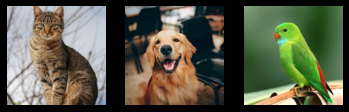

In [101]:
for j, img_path in enumerate(medoids):
		plt.subplot(1, len(medoids), j + 1)
		plt.axis('off')
		plt.imshow(Image.open(images_dir / img_path))

In [102]:
clusters = k_medoids(img_dict, medoids)

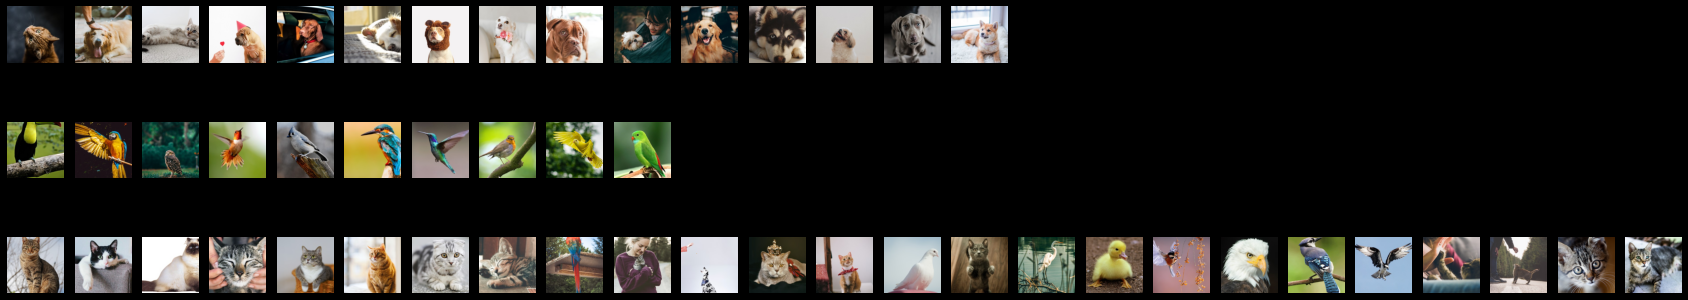

In [104]:
plt.figure(figsize=(30, 6))
rows = len(clusters)
cols = max([len(c) for c in clusters])
for i, cluster in enumerate(clusters):
	for j, img_path in enumerate(cluster):
		plt.subplot(rows, cols, i*cols + 1 + j)
		plt.axis('off')
		plt.imshow(Image.open(images_dir / img_path))


In [87]:
[1,2,3] == [1,2,3]

True

In [105]:
import random

In [125]:
random.seed(0)

In [127]:
random.sample([1,2,3,4,5,6], 3)

[3, 5, 4]

In [146]:
a = 323.1415
f"{a:1.2f}"

'323.14'

In [129]:
random.sample(img_dict.keys(), 3)

['pexels-japheth-mast-569170.jpg',
 'pexels-gratisography-2007.jpg',
 'pexels-mali-maeder-75973.jpg']

In [131]:
Path(images_dir)

WindowsPath('images_cropped')

In [149]:
a = [[]] *  10

In [152]:
a

[[123], [123], [123], [123], [123], [123], [123], [123], [123], [123]]